# Bayesian optimization with fixed features
In some contexts a variable/feature needs to be fixed during optimization. However, we
can leverage previous measurements near the fixed variable value to potentially
jump-start optimization using observed model covariances established by the GP kernel
. In this example, we start with a number of random observations in 2D input space
and then proceed with BO at a fixed value for one of the variables. This notebook
uses the 2D Rosenbrock test function as an example.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.resources.test_functions.rosenbrock import evaluate_rosenbrock,make_rosenbrock_vocs

# make rosenbrock function vocs in 2D
vocs = make_rosenbrock_vocs(2)

# define a fixed value for the BO generator
fixed_features = {"x0":-1.0}
generator = UpperConfidenceBoundGenerator(
    vocs=vocs, fixed_features=fixed_features
)
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.n_monte_carlo_samples = NUM_MC_SAMPLES

evaluator = Evaluator(function=evaluate_rosenbrock)

X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X


            Xopt
________________________________
Version: 0+untagged.1.gc8a1007
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: !!python/name:xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock ''
  function_kwargs:
    dummy: 1
    label: y
  max_workers: 1
  vectorized: false
generator:
  beta: 2.0
  computation_time: null
  fixed_features:
    x0: -1.0
  max_travel_distances: null
  model: null
  model_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: true
  n_candidates: 1
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    n_raw_samples: 20
    n_restarts: 20
    name: LBFGS
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
  objectives:
    y: MINIMIZE
  observables: []
  variables:
    x0:
    - -2.0
    - 2.0
    x1:
    - -2.0


## Generate some initial random samples in 2D space

In [2]:
X.random_evaluate(10)

,x0,x1,y,xopt_runtime,xopt_error
0,-1.774779,1.151293,407.118807,0.000013,False
1,0.547516,0.374045,0.756355,0.000004,False
2,-0.364350,1.620243,223.124653,0.000003,False
3,-0.692170,1.873237,197.225165,0.000003,False
4,0.466068,-1.856450,430.295403,0.000003,False
5,-1.230563,0.060304,216.381508,0.000003,False
6,-1.400072,0.104556,350.102583,0.000002,False
7,-0.237391,0.639702,35.560497,0.000023,False
8,0.599062,-0.015757,14.195635,0.000003,False
9,0.331531,-0.977889,118.778158,0.000003,False


## Run BO steps with fixed features

In [3]:
for i in range(5):
    X.step()

In [4]:
X.data

,x0,x1,y,xopt_runtime,xopt_error
0,-1.774779,1.151293,407.118807,0.000013,False
1,0.547516,0.374045,0.756355,0.000004,False
2,-0.364350,1.620243,223.124653,0.000003,False
3,-0.692170,1.873237,197.225165,0.000003,False
4,0.466068,-1.856450,430.295403,0.000003,False
5,-1.230563,0.060304,216.381508,0.000003,False
6,-1.400072,0.104556,350.102583,0.000002,False
7,-0.237391,0.639702,35.560497,0.000023,False
8,0.599062,-0.015757,14.195635,0.000003,False
9,0.331531,-0.977889,118.778158,0.000003,False


## Visualize model and evaluations
Note that for the BO samples, they all are on the line $x_0=-1$

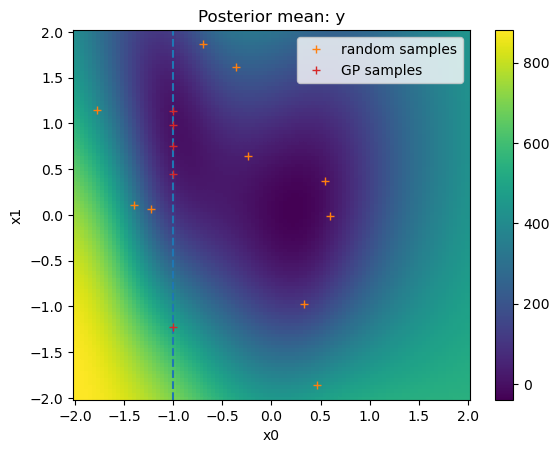

In [5]:
from matplotlib import pyplot as plt  # plot model predictions
import torch
data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.train_model(generator.data)

# create mesh
n = 100
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x0", "x1"]].to_numpy()[:10].T, "+C1",
                label="random samples",
                zorder=10
                )
        ax.plot(*data[["x0", "x1"]].to_numpy()[10:].T, "+C3",
                label="GP samples",
                zorder=10)


        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n)
        )
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")
        ax.axvline(-1.0,ls="--")
        ax.set_xlabel("x0")
        ax.set_ylabel("x1")
        ax.legend()